
ClusC of single:
[(4, array([4, 5, 6, 9]), 0.4),
 (3, array([0, 2, 3]), 0.4),
 (2, array([4, 6]), 0.35)]

ClusR of single:
[(4, array([ 0,  2, 10, 11]), 0.3),
 (3, array([ 5,  7, 18]), 0.3),
 (3, array([ 3,  6, 13]), 0.3),
 (2, array([16, 19]), 0.3),
 (2, array([ 8, 17]), 0.3),
 (2, array([ 6, 13]), 0.2)]

ClusC of complete:
[(6, array([0, 2, 4, 5, 6, 9]), 0.75),
 (4, array([1, 3, 7, 8]), 0.6),
 (3, array([0, 2, 5]), 0.5),
 (3, array([4, 6, 9]), 0.45),
 (2, array([7, 8]), 0.45),
 (2, array([1, 3]), 0.45),
 (2, array([0, 2]), 0.4),
 (2, array([4, 6]), 0.35)]

ClusR of complete:
[(7, array([ 4,  8,  9, 12, 14, 15, 17]), 0.8),
 (7, array([ 1,  7, 10, 11, 16, 18, 19]), 0.7),
 (6, array([ 0,  2,  3,  5,  6, 13]), 0.7),
 (5, array([ 8,  9, 12, 14, 17]), 0.7),
 (5, array([ 1,  7, 10, 11, 18]), 0.6),
 (3, array([ 8, 12, 17]), 0.5),
 (3, array([ 5,  6, 13]), 0.5),
 (3, array([ 1, 10, 11]), 0.5),
 (3, array([0, 2, 3]), 0.4),
 (2, array([ 4, 15]), 0.5),
 (2, array([ 9, 14]), 0.4),
 (2, array([16

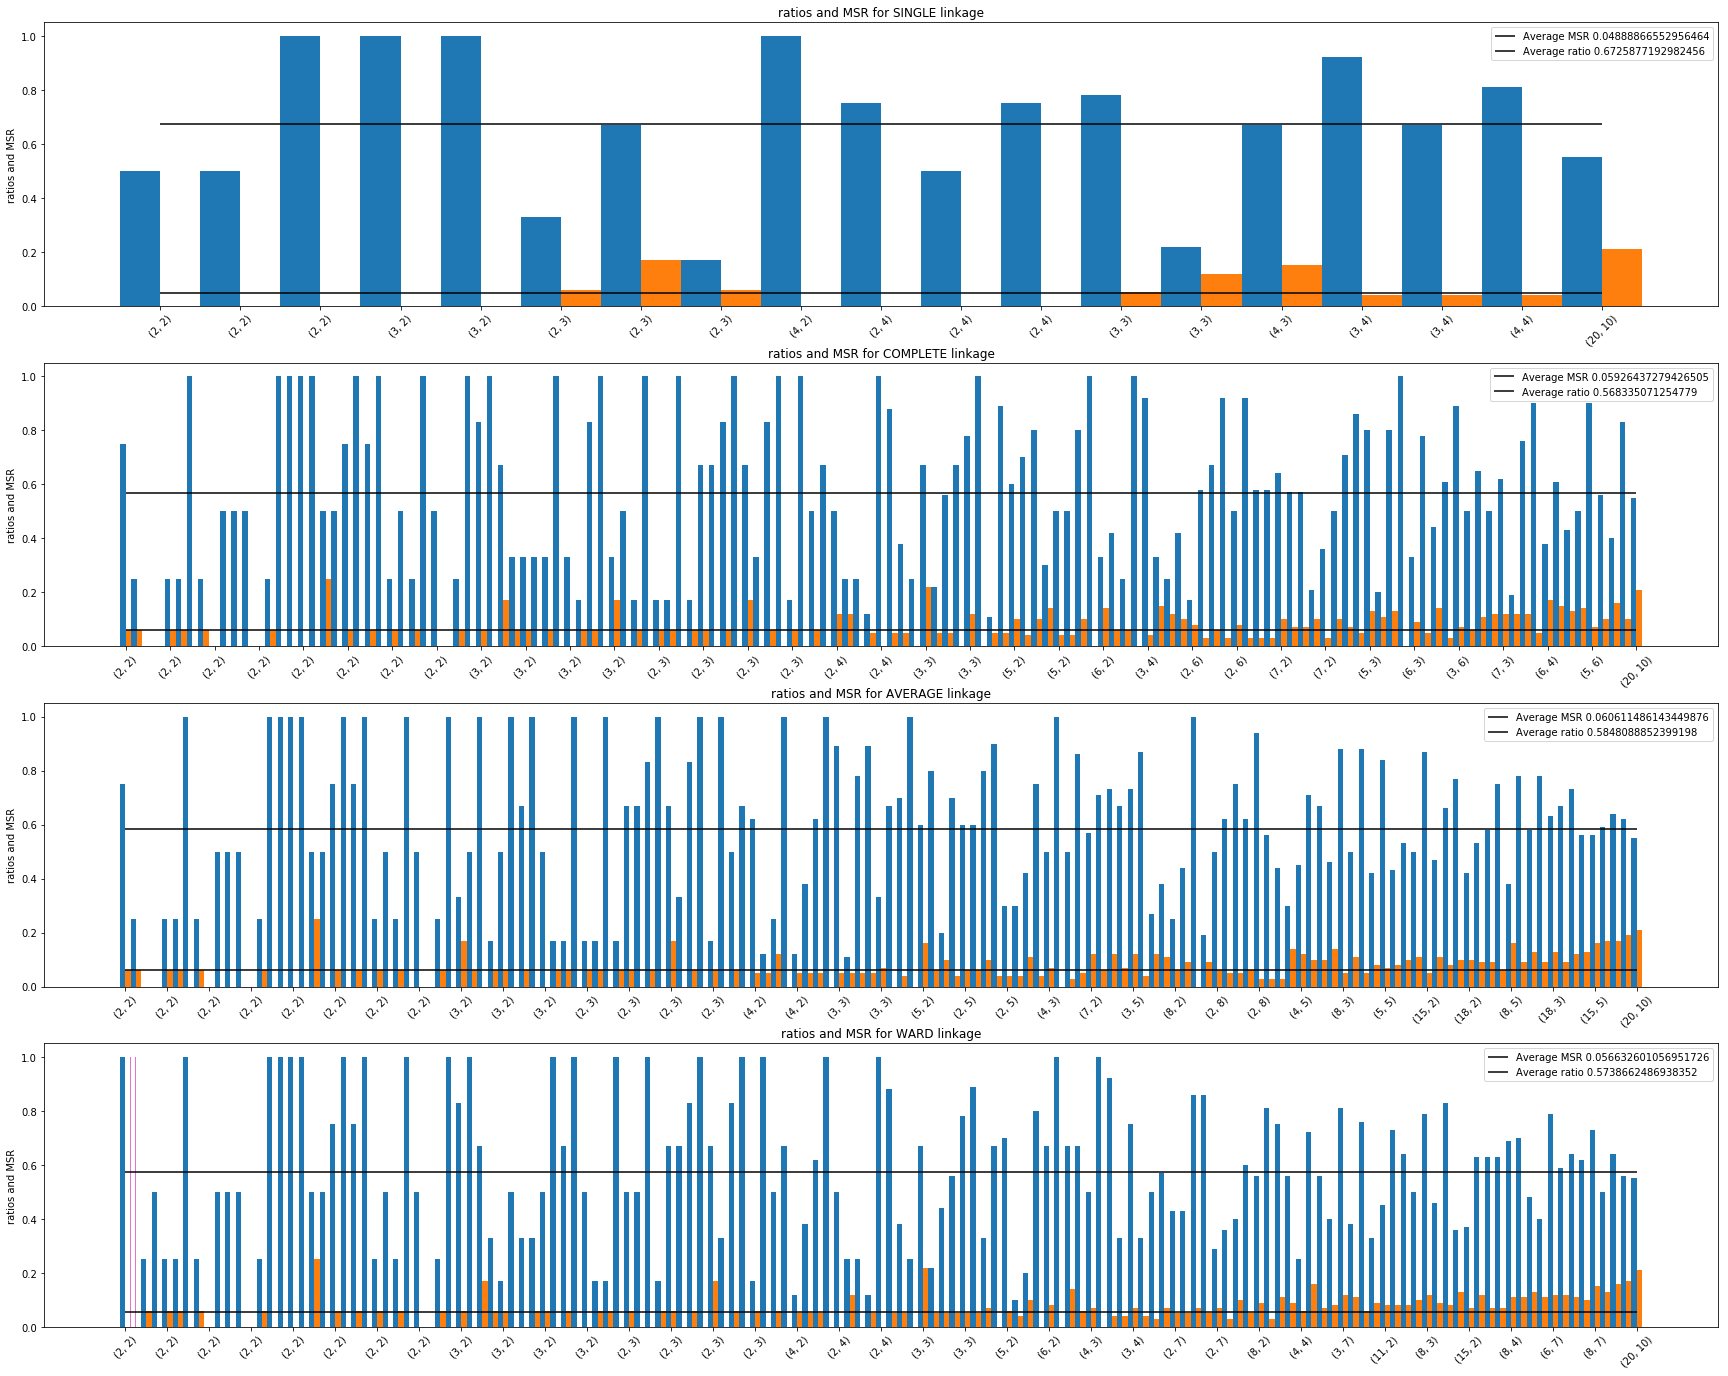

In [23]:
from scipy.cluster.hierarchy import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

methods = {'single':'hamming',
           'complete':'hamming',
           'average':'hamming',
           'ward':'euclidean' }


if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('imagesMR'):
    os.makedirs('imagesMR')


class HierBicluster(object):
    '''
    
    '''
    def __init__(self, mat, method, metric):
        mat = mat
        method = method
        metric = metric
        ZR = linkage(mat, method, metric)
        ZC = linkage(np.transpose(mat),method, metric)
       


def getClusters(Z):
#     from heapq import *
    from heapq import heappush, heappop
    j = 0
    clusters = []
    strlist = []
    dis = np.unique(Z[:,2]).tolist()
#     dis.append(1)
    if dis[0] == 0:
        dis = dis[1:]
    for hei in dis:
        cutree = cut_tree(Z, height=hei)
        labels = np.unique(cutree)
        for label in labels:
            temp = np.where(cutree == label)[0]
            strtemp = ','.join(map(str,temp))
            if strtemp in strlist:
                continue
            strlist.append(strtemp)
            if len(temp) > 1:
                heappush(clusters,(len(temp),j,temp,round(hei,2)))
                j += 1
    table = [heappop(clusters) for i in range(len(clusters))][::-1]
    return [(item[0],item[2],item[3]) for item in table ]


def plot_table(axes, df, sub_mat = None, title = 'matrix'):
    axes.set_title(title)
    data = df.values
    axes.axis('off')
    stripe = np.empty(np.array(data).shape, dtype=np.dtype(('U10', 1)) )
    rowColours = []
    colWidths = [0.12 for _ in range(0, stripe.shape[0])]
    for i in range(0,stripe.shape[0]):
        for j in range(0, stripe.shape[1]):

            if i % 2 == 0:
                stripe[i,j] = '0.9'

            else:
                stripe[i,j] = 'w'
    if sub_mat is not None:
        for i in sub_mat[0]:
            for j in sub_mat[1]:
                stripe[i,j] = 'g'

    rowColours = []
    for j in range(0, stripe.shape[0]):
        if j % 2 == 0:    
            rowColours.append('0.9')
        else:
            rowColours.append('1.0')
    stripe
    axes.table(cellText=data,
                          cellColours=stripe,
                          rowColours = rowColours,
                          loc='center',
                          rowLabels=list(df.index),
                          colLabels=list(df.columns),
                          colWidths = colWidths,
                          )

def plot_parallel(ax, df, title = 'Parallel coordinates'):
    

    ax.set_title(title)
    df["index"] = df.index.values
    pd.plotting.parallel_coordinates(
            df, "index", ax=ax,
#             color=('#556270', '#4ECDC4', '#C7F464')
    )

    
def parallelPlot(ax, mat, submat, title):
    rows, cols = submat[0], submat[1]
    df = pd.DataFrame(mat[rows][:,cols],
                      index=rows,columns=cols)
    plot_parallel(ax,df,title=title)



def hClustering(mat,method, metric):
    ZR = linkage(mat,method, metric)
    ZC = linkage(np.transpose(mat),method, metric)
    clusR = getClusters(ZR)
    clusC = getClusters(ZC)
    import pprint
    pp = pprint.PrettyPrinter(indent=1)
    
    print(f'\nClusC of {method}:')
    pp.pprint(clusC)
    print(f'\nClusR of {method}:')
    pp.pprint(clusR)

    return clusR, clusC



 
def biclus(clusR, clusC):
    from heapq import heappush, heappop
    bis = []
    i = 0
    for cr in clusR:
        for cc in clusC:
            dims = cr[0]*cc[0]
            heappush(bis, (dims, i, (cr[1],cc[1]),( cr[0],cc[0]) ))
            i += 1
            
    return [heappop(bis) for i in range(len(bis))]

def MSR(a): 
    return (np.power(a - a.mean(axis=1, keepdims=True) -
                                 a.mean(axis=0) + a.mean(), 2).mean())


def ratioMSR(mat,clusR, clusC):
    bis = biclus(clusR,clusC)
    rows = np.arange(mat.shape[0])
    cols = np.arange(mat.shape[1])
    i = 0
    rmsr = []
    subs = []
    
    ave = [0.0,0.0]
    for bi in bis:
        
        submat = mat[bi[2][0]][:,bi[2][1]]
        subs.append(submat)
        count = np.count_nonzero(submat==0)
        ratio = 1- float(count) / float(submat.size)
        msr = MSR(submat)
        ave[0] += msr
        ave[1] += ratio
#         subs.append(bi[2])       
        rmsr.append((bi[3],round(ratio, 2), round(msr,2), i))
        i += 1
        
    
    count = np.count_nonzero(mat==0)
    ratio = 1- float(count) / float(mat.size)
    msr = MSR(mat)
    ave[0] += msr
    ave[1] += ratio
    i += 1
    
    rmsr.append((mat.shape,round(ratio, 2), round(msr,2),i))
#     subs.append((rows,cols))
    subs.append(mat)
        
    return np.array(rmsr), (ave[0]/i,ave[1]/i), subs


def plot_rmsr(ax,rmsr,ave, method):
    labels = rmsr[:,0]
    x = np.arange(len(rmsr))  # the label locations
    width = 0.5  # the width of the bars
    ax.bar(x - width/2, rmsr[:,1], width)
    ax.bar(x + width/2, rmsr[:,2], width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'ratios and MSR')
    ax.set_title(f'ratios and MSR for {str.upper(method)} linkage')
    
    h1 = ax.hlines(ave[0], x[0],x[-1],label=f'Average MSR {ave[0]}')
    h2 = ax.hlines(ave[1], x[0],x[-1],label=f'Average ratio {ave[1]}')
    
    if method == 'single':
        ax.set_xticks(x)
        ax.set_xticklabels(labels,rotation = 45)
    else:

        labels = [labels[i] for i in range(0,len(labels),4)]
        x = [x[i] for i in range(0,len(x),4)]
        ax.set_xticks(x)
        ax.set_xticklabels(labels,rotation = 45)
    ax.legend(handles=[h1,h2])



    



 




methods = {'single':'hamming',
           'complete':'hamming',
           'average':'hamming',
           'ward':'euclidean' }



mat = np.load('data/matrix.npy')
size = mat.shape
figsize = (size[0]*1.5,6*len(methods))
fig, axes = plt.subplots(nrows=len(methods),figsize=figsize,constrained_layout=False)

i = 0
for method, metric in methods.items():
    clusR, clusC = hClustering(mat,method,metric)
    rmsr, ave, subs = ratioMSR(mat,clusR, clusC)
    plot_rmsr(axes[i],rmsr, ave, method)
    i += 1
    
    
    




fig.savefig(f'imagesMR/ratioMSR_4.pdf')
plt.show()  



ClusC of single:
[(4, array([4, 5, 6, 9]), 0.4),
 (3, array([0, 2, 3]), 0.4),
 (2, array([4, 6]), 0.35)]

ClusR of single:
[(4, array([ 0,  2, 10, 11]), 0.3),
 (3, array([ 5,  7, 18]), 0.3),
 (3, array([ 3,  6, 13]), 0.3),
 (2, array([16, 19]), 0.3),
 (2, array([ 8, 17]), 0.3),
 (2, array([ 6, 13]), 0.2)]

ClusC of complete:
[(6, array([0, 2, 4, 5, 6, 9]), 0.75),
 (4, array([1, 3, 7, 8]), 0.6),
 (3, array([0, 2, 5]), 0.5),
 (3, array([4, 6, 9]), 0.45),
 (2, array([7, 8]), 0.45),
 (2, array([1, 3]), 0.45),
 (2, array([0, 2]), 0.4),
 (2, array([4, 6]), 0.35)]

ClusR of complete:
[(7, array([ 4,  8,  9, 12, 14, 15, 17]), 0.8),
 (7, array([ 1,  7, 10, 11, 16, 18, 19]), 0.7),
 (6, array([ 0,  2,  3,  5,  6, 13]), 0.7),
 (5, array([ 8,  9, 12, 14, 17]), 0.7),
 (5, array([ 1,  7, 10, 11, 18]), 0.6),
 (3, array([ 8, 12, 17]), 0.5),
 (3, array([ 5,  6, 13]), 0.5),
 (3, array([ 1, 10, 11]), 0.5),
 (3, array([0, 2, 3]), 0.4),
 (2, array([ 4, 15]), 0.5),
 (2, array([ 9, 14]), 0.4),
 (2, array([16

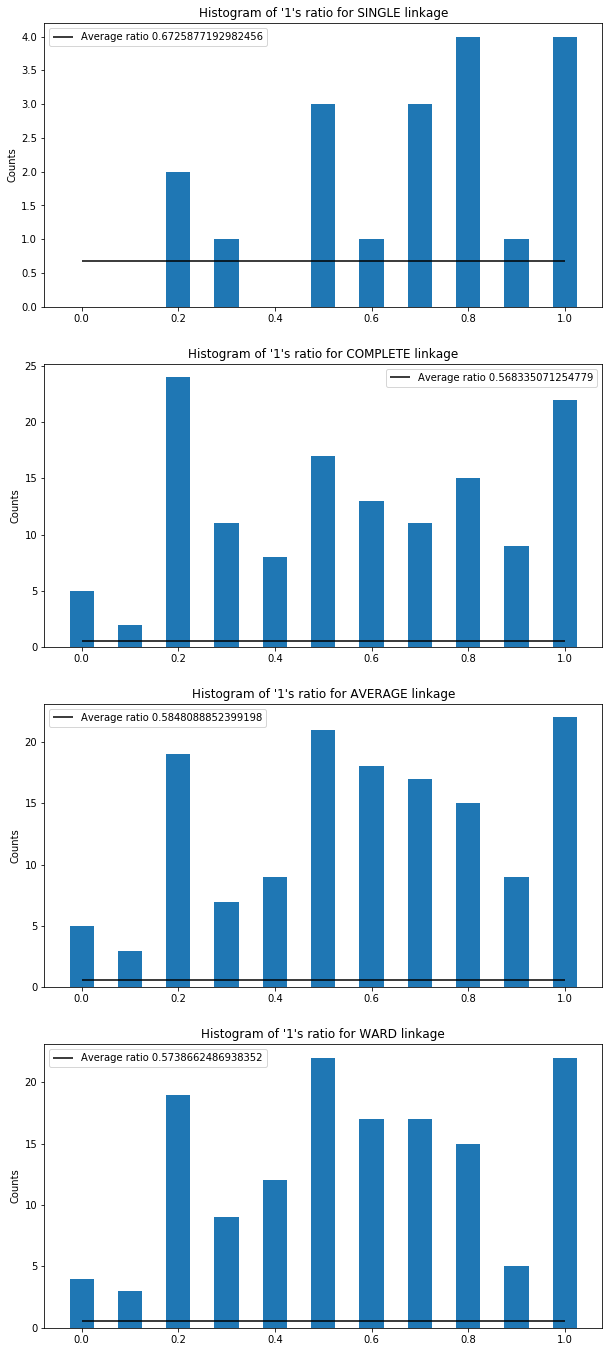

In [63]:
def plot_rmsr_hist(ax,rmsr,ave, method):
    bins=[-0.05 + i*0.1 for i in range(12)]
    ax.hist(rmsr[:,1].astype(float),bins = bins,rwidth = 0.5)
 
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'Counts')
    ax.set_title(f'Histogram of \'1\'s ratio for {str.upper(method)} linkage')
    
#     h1 = ax.hlines(ave[0],0,1,label=f'Average MSR {ave[0]}')
    h2 = ax.hlines(ave[1],0,1,label=f'Average ratio {ave[1]}')
    ax.legend(handles=[h2])




figsize = (size[0]*0.5,6*len(methods))
fig_his, axes_his = plt.subplots(nrows=len(methods),figsize=figsize,constrained_layout=False)

rmsrs,aves = [], []
i = 0
for method, metric in methods.items():
    clusR, clusC = hClustering(mat,method,metric)
    rmsr, ave, subs = ratioMSR(mat,clusR, clusC)
    plot_rmsr_hist(axes_his[i],rmsr, ave, method)
    i += 1
    rmsrs.append(rmsr)
    aves.append(ave)
fig_his.savefig(f'imagesMR/ratioHis.pdf')
plt.show()  

/home/haoyu/miniconda3/envs/holoviz-tutorial/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '
/home/haoyu/miniconda3/envs/holoviz-tutorial/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


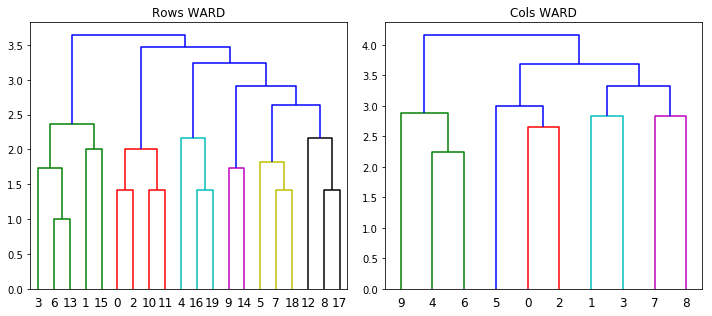

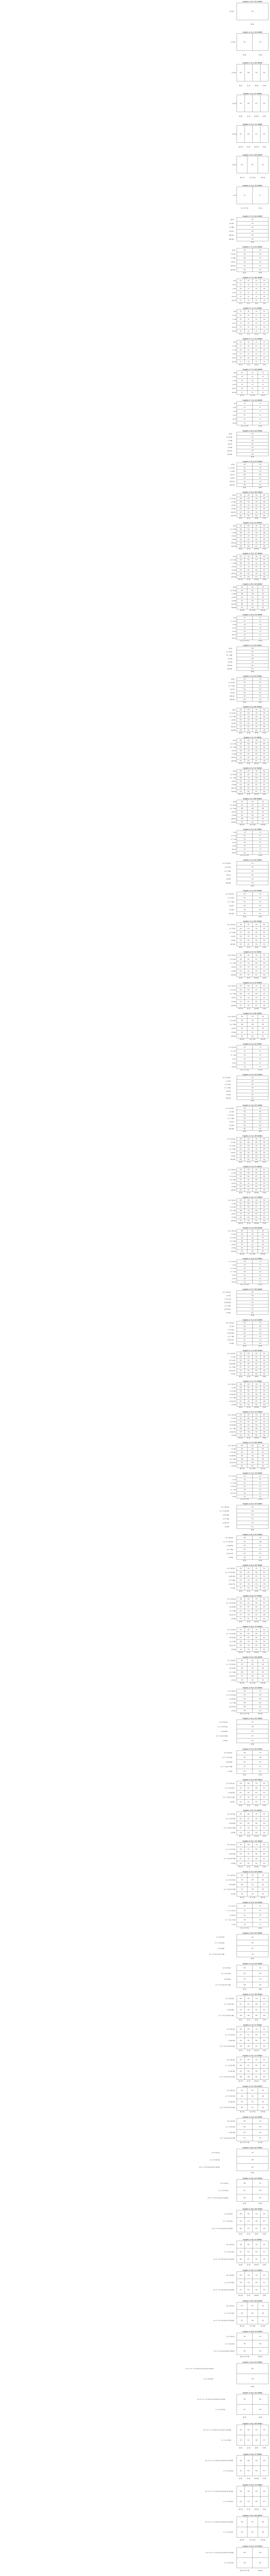

In [218]:
def checkerboard_plot(ary, ax, title="hello",
                      cell_colors=('white', 'white'),
                      font_colors=('black', 'black'),
                      fmt='%.1f',
                      row_labels=None,
                      col_labels=None,
                      fontsize=None):

    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    n_rows, n_cols = ary.shape

    if row_labels is None:
        row_labels = np.arange(n_rows)
    if col_labels is None:
        col_labels = np.arange(n_cols)

    width, height = 1.0 / n_cols, 1.0 / n_rows
    
    maxR, maxC = 0, 0
    for row in row_labels:
        if len(row) > maxR:
            maxR = len(row)
    for col in col_labels:
        if len(col) > maxC:
            maxC = len(col)
            

    for (row_idx, col_idx), cell_val in np.ndenumerate(ary):

        idx = (col_idx + row_idx) % 2
        tb.add_cell(row_idx, col_idx, width*maxC/3, height,
                    text=fmt % cell_val,
                    loc='center',
                    facecolor=cell_colors[idx])

    for row_idx, label in enumerate(row_labels):
        tb.add_cell(row_idx, -1,
                    width*maxR/3, height,
                    text=label, loc='right',
                    edgecolor='none', facecolor='none')

    for col_idx, label in enumerate(col_labels):
        tb.add_cell(len(row_labels)+1, col_idx,
                    width*maxC/3, height / 2.,
                    text=label, loc='center',
                    edgecolor='none', facecolor='none')

    for (row_idx, col_idx), cell_val in np.ndenumerate(ary):
        idx = (col_idx + row_idx) % 2
        tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[idx])

    ax.add_table(tb)
    tb.set_fontsize(fontsize)
    
    ax.set_title(title)





def getClus(Z, dis):
    cutree = cut_tree(Z, height=dis)
    labels = np.unique(cutree)
    clus = []
    for label in labels:
        temp = np.where(cutree == label)[0]
        if len(temp) > 1:
            clus.append(temp)
    return clus
    

def plot_clusters(mat,method, metric):
    plt.rcParams.update({'figure.autolayout': True})
    
    ZR = linkage(mat,method, metric)
    ZC = linkage(np.transpose(mat),method, metric)
    
    fig_den, ax_den = plt.subplots(ncols=2,figsize=(10,4.5))
    dendrogram(ZR, ax=ax_den[0] )
    ax_den[0].set_title(f'Rows {str.upper(method)}')
    dendrogram(ZC, ax=ax_den[1] )
    ax_den[1].set_title(f'Cols {str.upper(method)}')
    fig_den.savefig(f'imagesMR/dendrogram{str.upper(method)}.pdf')

    
    
    disR = np.unique(ZR[:,2]).tolist()
    disC = np.unique(ZC[:,2]).tolist()
    
    clusR = []
    clusC = []
    for disr in disR:
        clusr = getClus(ZR, disr)
        if len(clusr) > 0:
            clusR.append([clusr, round(disr,2)])
    #         clusR[round(disr,2)] = clusr
    for disc in disC:
        clusc = getClus(ZC, disc)
        if len(clusc) > 0:
            clusC.append([clusc, round(disc,2)])
    #         clusC[round(disc,2)] = clusc

    
    total = len(clusR)*len(clusC)
            
    figsize=(4.5, 4.5*total)    
    fig, ax = plt.subplots(nrows=total,figsize=figsize)
    k=0
    for hr in clusR:
        for hc in clusC:
            i= 0
            ck = np.empty((len(hr[0]),len(hc[0])),dtype='float')
            for clus_r in hr[0]:
                j = 0
                for clus_c in hc[0]:  
                    submat = mat[clus_r][:,clus_c]                    
                    count = np.count_nonzero(submat==0)
                    ratio = 1- float(count) / float(submat.size)
                    ck[i][j] = ratio
                    j += 1
                i += 1
            checkerboard_plot(ck, ax[k],
                              title=f'Heights:({hr[1]},{hc[1]}) {str.upper(method)}',
                              col_labels=hc[0],
                              row_labels=hr[0], )
            k+=1


    fig.savefig(f'imagesMR/clusRatio{str.upper(method)}.pdf')
                    
                


methods = {'single':'hamming',
           'complete':'hamming',
           'average':'hamming',
           'ward':'euclidean' }     
for method, metric in methods.items():
    plot_clusters(mat,method, metric)


    


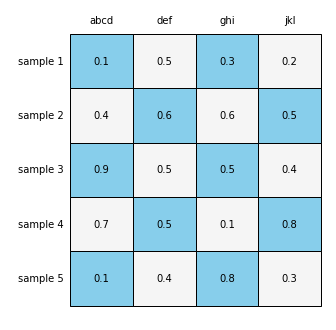

In [79]:
from mlxtend.plotting import checkerboard_plot

ary = np.random.random((5, 4))
checkerboard_plot(ary, 
                  col_labels=['abcd', 'def', 'ghi', 'jkl'],
                  row_labels=['sample %d' % i for i in range(1, 6)],
                  cell_colors=['skyblue', 'whitesmoke'],
                  font_colors=['black', 'black'],
                  figsize=(4.5, 5))
plt.show()